In [0]:
INPUT_FILE_NAME = 'log_sample.csv'
#'small_log.csv'
#'log_sample.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip "drive/My Drive/log_sample.zip" -d "."

Archive:  drive/My Drive/log_sample.zip
  inflating: ./log_sample.csv        


In [0]:
import csv
import numpy as np
from tqdm import tqdm

In [0]:
class Event:
    def __init__(self, timestamp, group_id, device_id, event_id, event_count):
        self.timestamp = int(timestamp)
        self.group_id = group_id
        self.event_id = event_id
        self.device_id = device_id
        if event_count:
            self.count = int(event_count)
        else:
            self.count = 0

In [0]:
def check_group_event_id(group_id, event_id):
    return group_id not in ('performance', 'vcs.change.reminder') and event_id not in ('ui.lagging',
            'ide.error',
            'ide.freeze',
            'ui.latency',
            'registered','invoked',
            'TsLintLanguageService',
            'whitelist.updated',
            'logs.send',
            'notification.shown',
            'ESLintLanguageService'
            )

In [0]:
def read_from_file_to_event_list():
    events = []
    isFirst = True
    with open(INPUT_FILE_NAME, 'r') as fin:
        for row in tqdm(csv.reader(fin, delimiter=',')):
            if isFirst:
                isFirst = False
                continue
            if (row[12].split('.')[0]) and check_group_event_id(row[5], row[10]):
                events.append(Event(row[3], row[5], row[7], row[10], row[12].split('.')[0]))
    return events        
            

In [8]:
events = read_from_file_to_event_list()

44349155it [06:12, 119083.82it/s]


In [0]:
import math

In [0]:
def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

In [0]:
def get_action_N_probs(events, forget_period):
    user_action_to_timestamps = {}
    action_N_to_p = {}
    actions = {}
    user_to_max_timestamp = {}
    user_action_to_max_diff = {}
    for elem in tqdm(events):
        user = elem.device_id
        group = elem.group_id
        event = elem.event_id
        timestamp = elem.timestamp
        if user in user_to_max_timestamp.keys():
            user_to_max_timestamp[user] = max(user_to_max_timestamp[user], timestamp)
        else:
            user_to_max_timestamp[user] = timestamp
        actions[(group, event)] = True
        if user in user_action_to_timestamps.keys():
            if (group, event) in user_action_to_timestamps[user].keys():
                user_action_to_timestamps[user][(group, event)].append(timestamp)
            else:
                user_action_to_timestamps[user][(group, event)] = [timestamp]
        else:
            user_action_to_timestamps[user] = {}
            user_action_to_timestamps[user][(group, event)] = [timestamp]
    
    maxN = 0
    for user in tqdm(user_action_to_timestamps.keys()):    
        user_action_to_max_diff[user] = {}
        for action in user_action_to_timestamps[user].keys():
            user_action_to_timestamps[user][action] = sorted(user_action_to_timestamps[user][action])
    
    for action in tqdm(actions.keys()):
        action_N_to_p[action] = {}
        for N in range(60, 0, -1):
            #print(N)
            done_after = 0
            total = 0
            for user in user_action_to_timestamps.keys():
                #print(user_action_to_timestamps[user].keys())
                #print(user_action_to_max_diff[user].keys())
                if action in user_action_to_timestamps[user].keys():
                    sorted_timestamps = user_action_to_timestamps[user][action]
                    prev = sorted_timestamps[0]
                    first_N = 0
                    for i in range(1, len(sorted_timestamps)):
                        elem = sorted_timestamps[i]
                        diff = round_half_up((elem - prev) / 1000 / 60 / 60 / 24)
                        if diff >= N:
                            total += 1
                            if diff <= forget_period:
                                done_after += 1
                        prev = elem
            if total != 0:
               # if N < 60:
               #     action_N_to_p[action][N] = max(action_N_to_p[action][N + 1], done_after / total)
               # else:
                    action_N_to_p[action][N] = done_after / total
            else:
                if N < 60:
                    action_N_to_p[action][N] = action_N_to_p[action][N + 1]
                else:
                    action_N_to_p[action][N] =  0
    return action_N_to_p
            

In [12]:
action_N_probs = get_action_N_probs(events, 30)

100%|██████████| 2551/2551 [18:43<00:00, 15.60it/s]


In [13]:
np.mean([action_N_probs[i][20] for i in action_N_probs.keys()])

0.26389632724215495

In [0]:
means = []
for N in range(1, 40):
    means.append(np.mean([action_N_probs[i][N] for i in action_N_probs.keys()]))

In [0]:

import matplotlib.pyplot as plt

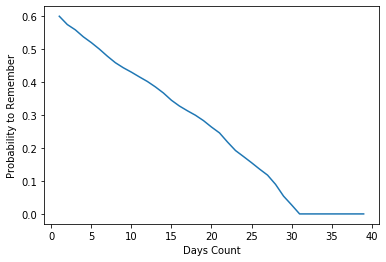

In [16]:
plt.plot(list(range(1, 40)), means)
plt.xlabel('Days Count')
plt.ylabel('Probability to Remember')
plt.show()